In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
from tqdm import tqdm

print('OpenCV: ', cv2.__version__)
print('TensorFlow: ', tf.__version__)

OpenCV:  3.4.1
TensorFlow:  1.8.0


## Load our trained model and some plug-points to predict

In [2]:
sess = tf.Session()

saver = tf.train.import_meta_graph('session/model.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint('./session/'))

graph = tf.get_default_graph()

features = graph.get_tensor_by_name('features:0')
Y_predict = graph.get_tensor_by_name('Y_predict:0')

INFO:tensorflow:Restoring parameters from ./session/model.ckpt


In [3]:
def pre_process_input_image(img):
    
    im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)
    
    ret, im_th = cv2.threshold(im_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    im_th = cv2.bitwise_not(im_th)
    # kernel = np.ones((3,3),np.uint8)
    # im_th = cv2.dilate(im_th,kernel,iterations = 1)
    return im_th

def get_digits_location(img):
    img = pre_process_input_image(img)
    json_dict = {}
    _, ctrs, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    json_dict = {}
    for i, rect in enumerate(rects):
        # Draw the rectangles
        # cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (119, 244, 66), 2) 
        # Make the rectangular region around the digit
        leng = int(rect[3] * 1.4)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        roi = img[pt1:pt1+leng, pt2:pt2+leng]
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = cv2.dilate(roi, (3, 3))
        json_dict[i] = roi
    return rects, json_dict

def plot_image(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')

def draw_digit_on_image(image, digit, rect):
#     cv2.rectangle(image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (119, 244, 66), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, str(int(digit)), (rect[0], rect[1]), font, rect[3]/40., (255,255,255), 2, cv2.LINE_AA)
    return image

In [4]:
def predict_from_image(img):
    img = img.reshape(-1, 28, 28, 1)
    number = tf.argmax(Y_predict, 1)
    return sess.run(number, feed_dict={features: img})



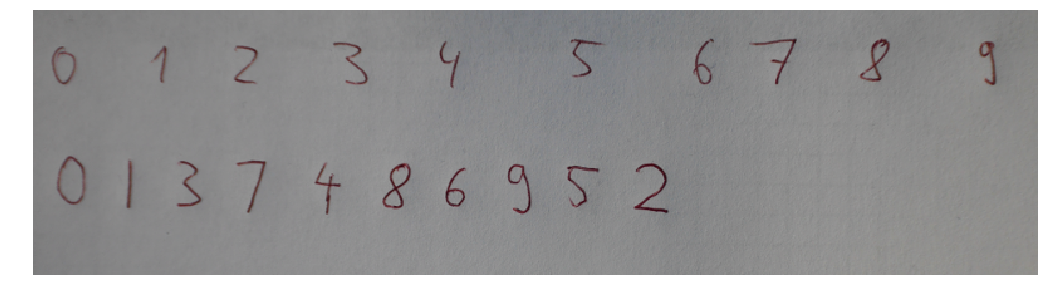

In [9]:
img = cv2.imread('digit.jpg')
plot_image(img)

In [6]:
rects, extracted_digit = get_digits_location(img)

In [7]:
for i in tqdm(range(len(rects))):
    img = draw_digit_on_image(img, predict_from_image(extracted_digit[i]), rects[i])


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


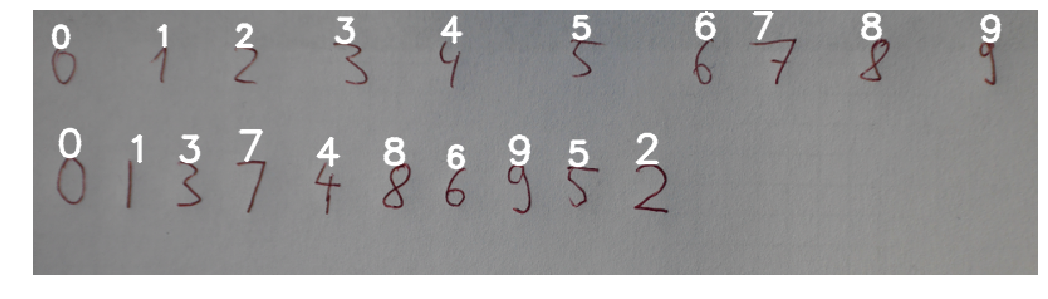

In [8]:
plt.rcParams["figure.figsize"] = [18,9]
plot_image(img)